In [1]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
# Filter test for store = 0 and product =0
test = test[(test['store'] == 0) & (test['product'] == 0)]

# Filter train for store = 0 and product =0
train = train[(train['store'] == 0) & (train['product'] == 0)]



In [3]:
# combine train and test and call it diff_data
diff_data = pd.concat([train, test])

In [4]:
# Convert diff data to numpy array of number_sold
diff_data = diff_data['number_sold'].values

diff_data = np.diff(diff_data)

# # scale the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# diff_data = scaler.fit_transform(diff_data.reshape(-1, 1))

In [5]:
def create_sequences(data, n_steps_in, n_steps_out=1):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])  # Slice for next step
    return np.array(X), np.array(y).reshape(-1, n_steps_out)  # Reshape y properly

# Generate sequences and targets from the differenced data
n_steps_in = 50  # Use last 50 steps to predict the next step
n_steps_out = 1  # Predict 1 step ahead

# Generate sequences from `diff_data`
X, y = create_sequences(diff_data, n_steps_in, n_steps_out)

# Now X and y should have the same number of samples
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (3601, 50), y shape: (3601, 1)


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [8]:
import torch
import torch.nn as nn

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.RNN(input_size + 1, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        sequence_length = x.size(1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        output = torch.zeros(batch_size, 1, 1).to(x.device)

        for t in range(sequence_length):
            combined_input = torch.cat((x[:, t:t+1, :], output), dim=2)
            out, h0 = self.rnn(combined_input, h0)
            output = self.fc(out)

        return output.squeeze(1)  # Return the final output


Epoch [5/100], Train Loss: 189.3575, Val Loss: 177.5459
Epoch [10/100], Train Loss: 184.4472, Val Loss: 173.1509
Epoch [15/100], Train Loss: 180.0056, Val Loss: 169.1327
Epoch [20/100], Train Loss: 175.9065, Val Loss: 165.3921
Epoch [25/100], Train Loss: 172.0945, Val Loss: 161.8984
Epoch [30/100], Train Loss: 168.5929, Val Loss: 158.6775
Epoch [35/100], Train Loss: 165.4205, Val Loss: 155.7257
Epoch [40/100], Train Loss: 162.4914, Val Loss: 153.0044
Epoch [45/100], Train Loss: 159.7916, Val Loss: 150.4983
Epoch [50/100], Train Loss: 157.3025, Val Loss: 148.1628
Epoch [55/100], Train Loss: 154.9947, Val Loss: 145.9791
Epoch [60/100], Train Loss: 152.8352, Val Loss: 143.9426
Epoch [65/100], Train Loss: 150.8092, Val Loss: 142.0411
Epoch [70/100], Train Loss: 148.8972, Val Loss: 140.2477
Epoch [75/100], Train Loss: 147.0797, Val Loss: 138.5061
Epoch [80/100], Train Loss: 145.3556, Val Loss: 136.8459
Epoch [85/100], Train Loss: 143.7167, Val Loss: 135.2687
Epoch [90/100], Train Loss: 142.

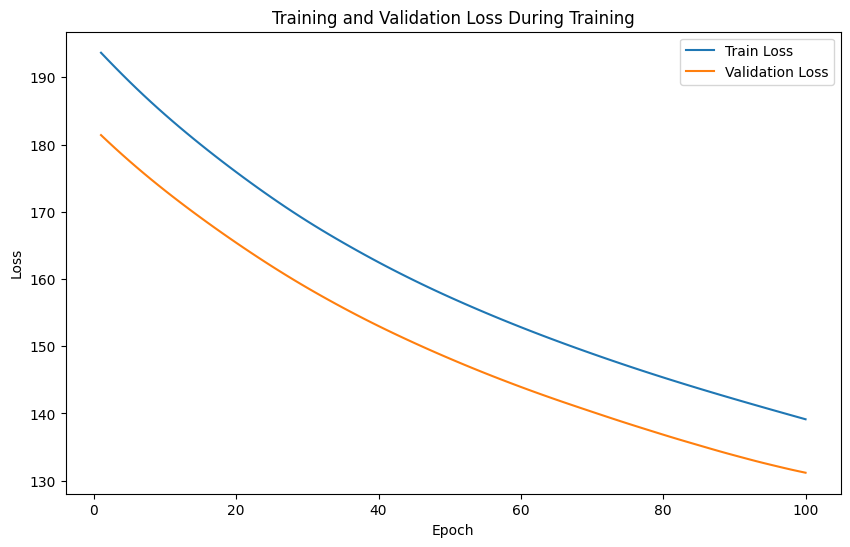

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to stop training when validation loss doesn't improve.
        Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 5
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize the model, loss, optimizer, and early stopping
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = JordanRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stopping = EarlyStopping(patience=10, min_delta=0.001)

import matplotlib.pyplot as plt

# Initialize lists to store the losses
train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass for training
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Store the validation loss
    val_losses.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss.item())
    if early_stopping.early_stop and epoch > 50:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss During Training')
plt.legend()
plt.show()


In [10]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 151.3999


In [13]:
criterion2 = nn.L1Loss()
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion2(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 9.8169


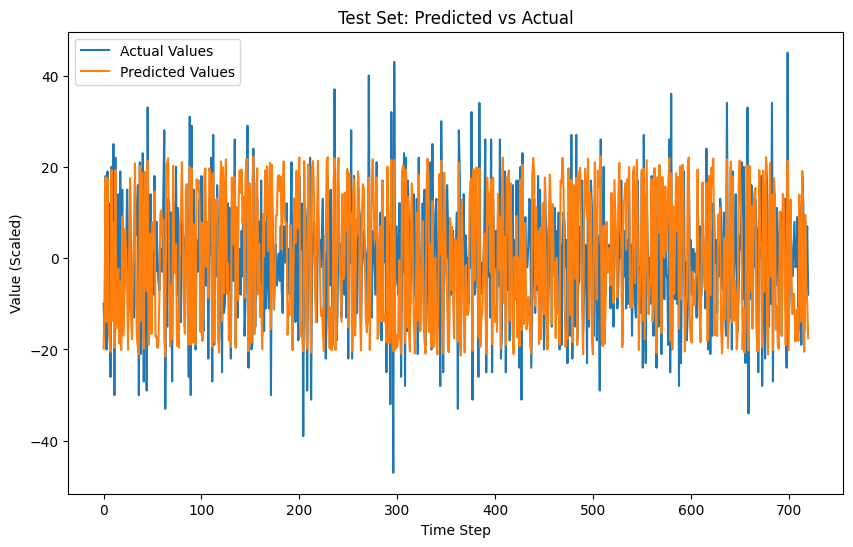

In [11]:
import matplotlib.pyplot as plt
# Plot predicted vs actual values
predicted_test = test_outputs.squeeze().numpy()*3
actual_test = y_test_tensor.numpy()

plt.figure(figsize=(10, 6))
plt.plot(actual_test, label='Actual Values')
plt.plot(predicted_test, label='Predicted Values')
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value (Scaled)')
plt.legend()
plt.show()


In [12]:
# import matplotlib.pyplot as plt
# # Plot predicted vs actual values
# predicted_test = test_outputs.squeeze().numpy()*3
# actual_test = y_test_tensor.numpy()

# plt.figure(figsize=(10, 6))
# plt.plot(actual_test, label='Actual Values')
# plt.plot(predicted_test, label='Predicted Values')
# plt.title('Test Set: Predicted vs Actual')
# plt.xlabel('Time Step')
# plt.ylabel('Value (Scaled)')
# plt.legend()
# plt.show()

# Plot using plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(actual_test)), y=actual_test.flatten(), mode='lines', name='Actual Values'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_test)), y=predicted_test.flatten(), mode='lines', name='Predicted Values'))
fig.update_layout(title='Test Set: Predicted vs Actual', xaxis_title='Time Step', yaxis_title='Value (Scaled)')
fig.show()


ModuleNotFoundError: No module named 'plotly'